In [1]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from string import punctuation
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import keras
from keras import backend as K
from keras import utils
from keras.optimizers import Adam


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv", header=0, delimiter="\t", quoting=3)

# Show the first ten rows of the dataset
dataset.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [0]:
Sentiment_words=[]
for row in dataset['Sentiment']:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('neutral')
    elif row == 2:
        Sentiment_words.append('somewhat negative')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
dataset['Sentiment_words'] = Sentiment_words

In [4]:
#MAking the word count
word_count=pd.value_counts(dataset['Sentiment_words'].values, sort=False)
word_count

somewhat positive    32927
somewhat negative    79582
negative              7072
positive              9206
neutral              27273
dtype: int64

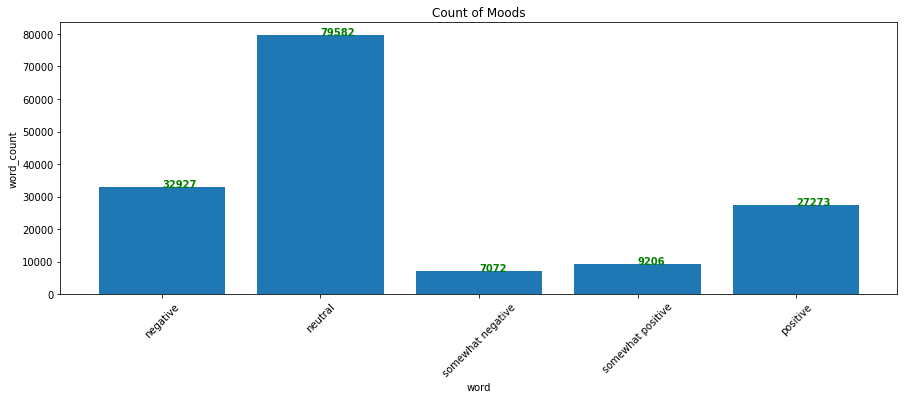

In [5]:
#plotting the sentiments from the dataset
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index,word_count,color = 'blue')
plt.xticks(Index,['negative','neutral','somewhat negative','somewhat positive','positive'],rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods')
plt.bar(Index, word_count)
for a,b in zip(Index, word_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

In [0]:
def retrive_full_sentence(df):
  num_sentences=df["SentenceId"].max()
  full_sentences=[]
  num_full_sentences=0
  for i in range(df.shape[0]):
    if df['SentenceId'][i] > num_full_sentences:
      full_sentences.append((df['Phrase'][i], df['Sentiment'][i]))
      num_full_sentences = num_full_sentences + 1
  full_sentences_df=pd.DataFrame(full_sentences, columns=['Phrase', 'Sentiment'])    
  return full_sentences_df

In [0]:
fullsens=retrive_full_sentence(dataset)
X_train=dataset["Phrase"]
Y_train=dataset["Sentiment"]

In [8]:
#Converting the X_train and Y_train to array using numpy
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_train.shape
Y_train.shape

(156060,)

In [0]:
#Cleaning the text :removing stopwords, puncuation, and lemmatizing
def clean_text(df):
  clean_phrase=[]
  for n in range(len(df)):
    phrases=str(df[n])
    phrases=re.sub('[^a-zA-Z]',' ',phrases).lower().split()
    phrases=[WordNetLemmatizer().lemmatize(phrase) for phrase in phrases if not phrase in stopwords.words('english')]
    use_words=' '.join(phrases)
    clean_phrase.append(use_words)
  return clean_phrase

In [0]:
#Cleaning the training part for removal of unwanted words,lemmatizers and punctuations
clean_X=clean_text(X_train)

In [0]:
#Code for TF-IDF
x_train, x_test, y_train, y_test = train_test_split(clean_X,Y_train, test_size=0.3, random_state=2003)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

max_feature = 2500
vectorizer = TfidfVectorizer(max_features=max_feature, min_df=4, max_df=0.8, ngram_range=(1,1))

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()


In [0]:
y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5)

In [13]:
# Resahaping the inputs in order to match the requirement
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_train.shape
x_test.shape

(46818, 2500, 1)

In [0]:
#defining the functions for the Parameter Calculations
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
#Creating The Model using Keras
model = Sequential(name='cnnMultiClassSentimentReg')

model.add(Conv1D(filters=64, kernel_size=3,activation='relu',input_shape=(2500,1)))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [16]:
#Model Summary Architecture
model.summary()

Model: "cnnMultiClassSentimentReg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2498, 64)          256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2494, 128)         41088     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2490, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2490, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 318720)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20398144  
_________________________________________________________________
dense_2 (Dense)              (None, 5)   

In [17]:
#Initializing the Optimizer and Model Compile
optimizer=Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy', recall_m, precision_m, f1_m])

In [18]:
# MOdel fitting with epochs and weights
history=model.fit(x_train, y_train, batch_size=128, epochs=15, verbose=1, validation_data=(x_test,y_test), class_weight=class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 109242 samples, validate on 46818 samples
Epoch 1/15





109242/109242 [==============================] - 75s 683us/step - loss: 1.0990 - acc: 0.5669 - recall_m: 0.3911 - precision_m: 0.6180 - f1_m: 0.4705 - val_loss: 0.9843 - val_acc: 0.6106 - val_recall_m: 0.4920 - val_precision_m: 0.6766 - val_f1_m: 0.5693
Epoch 2/15
109242/109242 [==============================] - 61s 556us/step - loss: 0.9600 - acc: 0.6202 - recall_m: 0.5020 - precision_m: 0.6851 - f1_m: 0.5784 - val_loss: 0.9761 - val_acc: 0.6127 - val_recall_m: 0.5045 - val_precision_m: 0.6716 - val_f1_m: 0.5758
Epoch 3/15
109242/109242 [==============================] - 61s 555us/step - loss: 0.9257 - acc: 0.6312 - recall_m: 0.5301 - precision_m: 0.6887 - f1_m: 0.5983 - val_loss: 0.9614 - val_acc: 0.6194 - val_recall_m: 0.5033 - val_precision_m: 0.6773 - val_f1_m: 0.5772
Epoch 4/15
109242/109242 [==========================

In [0]:
#Save the model for immediate use
model.save('1106925_1dconv_reg.h5')

In [0]:
from keras.models import load_model
#load the model for resuse
model = load_model('1106925_1dconv_reg.h5',custom_objects={'recall_m': recall_m,'precision_m': precision_m,'f1_m': f1_m})

In [21]:
#Evaluate the scores calculated
evaluate = model.evaluate(x_test, y_test, batch_size=128)
print('The testing accuracy is : ',evaluate[1])
print('Testing precision: ',evaluate[2])
print('Testing recall: ',evaluate[3])
print('Testing f1 score is: ', evaluate[4])

46818/46818 [==============================] - 8s 167us/step
The testing accuracy is :  0.624973300879919
Testing precision:  0.5825537186144785
Testing recall:  0.648501976841339
Testing f1 score is:  0.6136119760892144


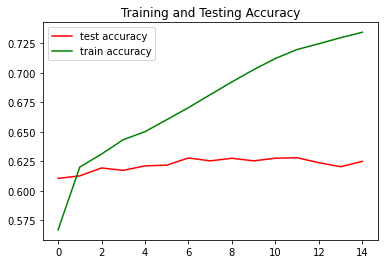

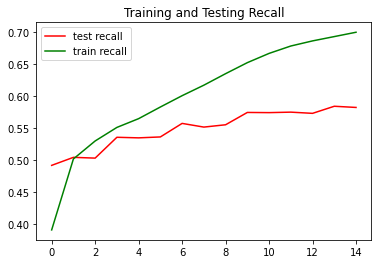

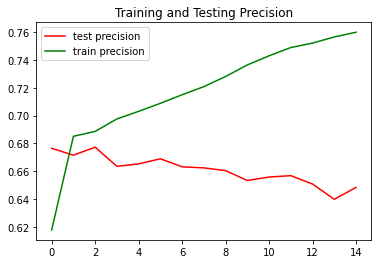

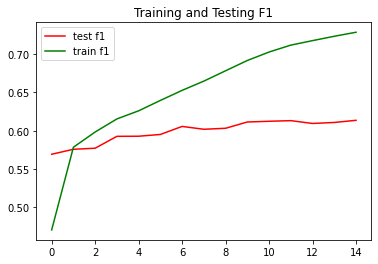

In [23]:
#Graph plot comparing the testing and training parameters 
x=range(0,15)

train_loss=history.history['loss']
test_acc=history.history['val_acc']
train_acc=history.history['acc']

test_f1=history.history['val_f1_m']
train_f1=history.history['f1_m']

test_recall=history.history['val_recall_m']
train_recall=history.history['recall_m']

test_prec=history.history['val_precision_m']
train_prec=history.history['precision_m']

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_prec, 'r')
plt.plot(x, train_prec, 'g')
plt.title('Training and Testing Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('Training and Testing F1')
plt.legend(['test f1', 'train f1'])